In [1]:

## IMPORTING THE LIBRARIES
import numpy as np  # linear algebra
import pandas as pd  # Handling dataframes 
import seaborn as sns #For plotting
import matplotlib.pyplot as plt
#from datetime import datetime #For fancy timestamps

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#LOADING THE DATASET

#data_wine=pd.read_csv('C:/Users/Varghese/Desktop/Code/Knight ML Assignment/Data/train.csv')
from google.colab import files
uploaded = files.upload()
import io
data_wine = pd.read_csv(io.BytesIO(uploaded['train.csv']))
data_wine.head()

Saving train.csv to train (5).csv


,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,It's impressive what a small addition of Sauvi...,L'Abbaye,87,22.0,Southwest France,Bergerac Sec,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,"This ripe, sweet wine is rich and full of drie...",Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,NaN,Château du Cèdre,Malbec


In [4]:
data_wine.shape

(82657, 12)

In [5]:
#CREATING A NEW DATASET (df1) WITH JUST REVIEW DESCRIPTION AND VARIETY NAME; FOR A PURELY TEXT BASED CLASSIFIER
df1 = data_wine[['review_description', 'variety']].copy()
df1

,review_description,variety
0,"Classic Chardonnay aromas of apple, pear and h...",Chardonnay
1,This wine is near equal parts Syrah and Merlot...,Red Blend
2,Barolo Conca opens with inky dark concentratio...,Nebbiolo
3,It's impressive what a small addition of Sauvi...,Bordeaux-style White Blend
4,"This ripe, sweet wine is rich and full of drie...",Malbec
...,...,...
82652,"Hot earth, baked cherry and mild vanilla aroma...",Tempranillo
82653,"Pungent, high-pitched notes of turmeric and dr...",Cabernet Sauvignon
82654,This is a wine that's not just lively and frui...,Gamay
82655,"An impressive wine, it already shows signs of ...",Bordeaux-style Red Blend


In [6]:
#VIEWING DTYPES, AND NULL-VALUES IN THE DATASET
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82657 entries, 0 to 82656
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   review_description  82657 non-null  object
 1   variety             82657 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [7]:
#ADDING A NUMERICAL CATEGORY ID TO EACH OF THE VARIETY
df1['category_id'] = df1['variety'].factorize()[0]
category_id_df = df1[['variety', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'variety']].values)
df1

,review_description,variety,category_id
0,"Classic Chardonnay aromas of apple, pear and h...",Chardonnay,0
1,This wine is near equal parts Syrah and Merlot...,Red Blend,1
2,Barolo Conca opens with inky dark concentratio...,Nebbiolo,2
3,It's impressive what a small addition of Sauvi...,Bordeaux-style White Blend,3
4,"This ripe, sweet wine is rich and full of drie...",Malbec,4
...,...,...,...
82652,"Hot earth, baked cherry and mild vanilla aroma...",Tempranillo,25
82653,"Pungent, high-pitched notes of turmeric and dr...",Cabernet Sauvignon,5
82654,This is a wine that's not just lively and frui...,Gamay,9
82655,"An impressive wine, it already shows signs of ...",Bordeaux-style Red Blend,11


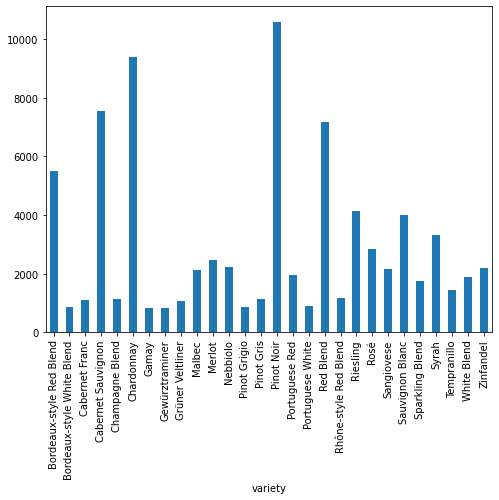

In [8]:
#PLOTTING THE DESCRIPTION BY VARIETY
fig = plt.figure(figsize=(8,6))
df1.groupby('variety').review_description.count().plot.bar(ylim=0)
plt.show()

In [11]:
# IMPORT Term Frequency, Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfVectorizer
#Change min_df value to ≤ 10 for best results. WARNING: CONSUMES HIGH MEMORY
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=25, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df1.review_description).toarray()
labels = df1.category_id
features.shape

(82657, 13600)

In [12]:
from sklearn.feature_selection import chi2
N = 2
for variety, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(variety))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bordeaux-style Red Blend':
  . Most correlated unigrams:
. bordeaux
. sample
  . Most correlated bigrams:
. black currant
. barrel sample
# 'Bordeaux-style White Blend':
  . Most correlated unigrams:
. sémillon
. botrytis
  . Most correlated bigrams:
. herbaceous character
. sémillon blend
# 'Cabernet Franc':
  . Most correlated unigrams:
. cab
. franc
  . Most correlated bigrams:
. cabernet franc
. cab franc
# 'Cabernet Sauvignon':
  . Most correlated unigrams:
. cassis
. cab
  . Most correlated bigrams:
. flavors blackberries
. 100 cabernet
# 'Champagne Blend':
  . Most correlated unigrams:
. nonvintage
. champagne
  . Most correlated bigrams:
. high dosage
. dry champagne
# 'Chardonnay':
  . Most correlated unigrams:
. buttered
. chardonnay
  . Most correlated bigrams:
. tropical fruit
. buttered toast
# 'Gamay':
  . Most correlated unigrams:
. cru
. beaujolais
  . Most correlated bigrams:
. cherry fruits
. cru wine
# 'Gewürztraminer':
  . Most correlated unigrams:
. lychee
. gew

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
X_train, X_test, y_train, y_test = train_test_split(df1['review_description'], df1['variety'], random_state = 42)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = LinearSVC().fit(X_train_tfidf, y_train) #Changed to LinearSVC for better score

In [14]:
#PREDICTION 1
print(clf.predict(count_vect.transform(["This wine is near equal parts Syrah and Merlot with the balance Cabernet Sauvignon. Aromas of blue fruit, vanilla, cherry and herb lead to full-bodied pit-fruit flavors that bring a sense of deliciousness that is hard to resist."])))

['Red Blend']


In [15]:
#CHECK 1
df1[df1['review_description'] == "This wine is near equal parts Syrah and Merlot with the balance Cabernet Sauvignon. Aromas of blue fruit, vanilla, cherry and herb lead to full-bodied pit-fruit flavors that bring a sense of deliciousness that is hard to resist."]

,review_description,variety,category_id
1,This wine is near equal parts Syrah and Merlot...,Red Blend,1


In [19]:
#PREDICTION 2
print(clf.predict(count_vect.transform(["Piercing on the nose, with toasty oak scents, mint and lemon along with standard blackberry and raspberry. Feels good and tight, with a structured composition and bright flavors of cherry, plum and toast. Turns chocolaty and a touch salty on the finish. A nice, stocky, lively wine."])))

['Malbec']


In [20]:
#CHECK 2
df1[df1['review_description'] == "Piercing on the nose, with toasty oak scents, mint and lemon along with standard blackberry and raspberry. Feels good and tight, with a structured composition and bright flavors of cherry, plum and toast. Turns chocolaty and a touch salty on the finish. A nice, stocky, lively wine."]

,review_description,variety,category_id
48022,"Piercing on the nose, with toasty oak scents, ...",Malbec,4


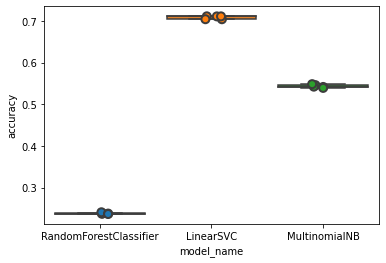

In [21]:
# BENCHMARKING ON MULTIPLE MODELS
# Logistic regression; Random Forest Classifier; Linear SupportVector Classifier; Naive Bayes (Multinomial)
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42),
    LinearSVC(),
    MultinomialNB()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [22]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.708228
MultinomialNB             0.543547
RandomForestClassifier    0.238274
Name: accuracy, dtype: float64

In [0]:
#ASSUMING LINEARSVC GAVE THE BEST SCORE IN THE CELL ABOVE
from sklearn.svm import LinearSVC
model = LinearSVC() # RandomForestClassifier(n_estimator=200, max_depth=3, random_state=42) # MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df1.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)

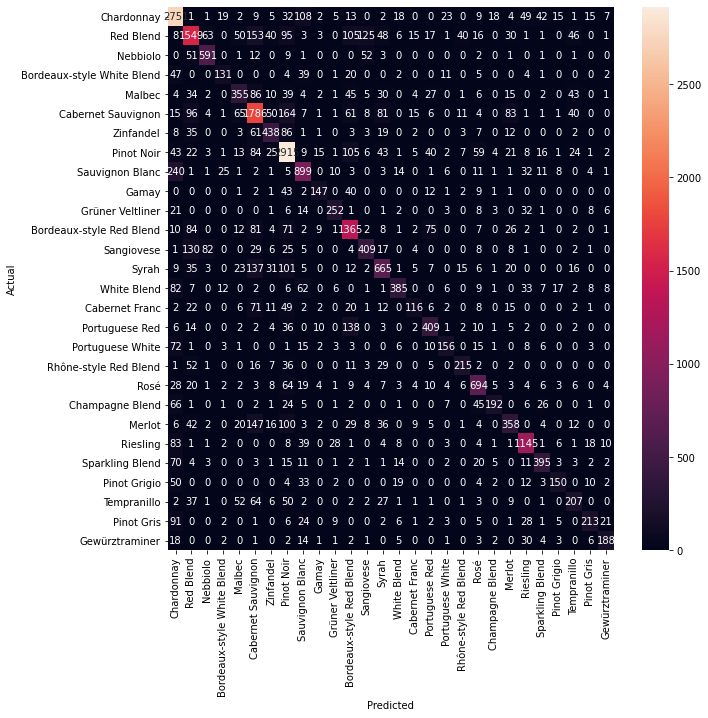

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.variety.values, yticklabels=category_id_df.variety.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
#The majority of predictions should be on the diagonals

In [0]:
#Checking the discrepancies here, using confusion matrix for false positives.
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df1.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['variety', 'review_description']])
      print('')

In [0]:
#Not an important step. Just a cross-verification.
model.fit(features, labels)
N = 2
for variety, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(variety))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [25]:
#SCORE-SHEET FOR EACH VARIETY
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df1['variety'].unique()))

                            precision    recall  f1-score   support

                Chardonnay       0.74      0.87      0.80      3151
                 Red Blend       0.69      0.64      0.67      2416
                  Nebbiolo       0.78      0.82      0.80       725
Bordeaux-style White Blend       0.65      0.49      0.56       267
                    Malbec       0.58      0.50      0.54       716
        Cabernet Sauvignon       0.65      0.71      0.68      2502
                 Zinfandel       0.66      0.64      0.65       684
                Pinot Noir       0.73      0.84      0.78      3476
           Sauvignon Blanc       0.68      0.70      0.69      1281
                     Gamay       0.73      0.56      0.63       262
          Grüner Veltliner       0.78      0.70      0.74       359
  Bordeaux-style Red Blend       0.68      0.77      0.73      1766
                Sangiovese       0.65      0.56      0.60       732
                     Syrah       0.64      0.61

In [26]:
from google.colab import files
uploaded = files.upload()
import io
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
test.head()

Saving test.csv to test (3).csv


,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,Nicely differentiated from the companion Stewa...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars
1,@wineschach,Argentina,Mendoza Vineyards 2012 Gran Reserva by Richard...,"Charred, smoky, herbal aromas of blackberry tr...",Gran Reserva by Richard Bonvin,90,60.0,Mendoza Province,Mendoza,NaN,Mendoza Vineyards
2,@vboone,US,Prime 2013 Chardonnay (Coombsville),"Slightly sour and funky in earth, this is a re...",NaN,87,38.0,California,Coombsville,Napa,Prime
3,@wineschach,Argentina,Bodega Cuarto Dominio 2012 Chento Vineyard Sel...,"This concentrated, midnight-black Malbec deliv...",Chento Vineyard Selection,91,20.0,Mendoza Province,Mendoza,NaN,Bodega Cuarto Dominio
4,@kerinokeefe,Italy,SassodiSole 2012 Brunello di Montalcino,"Earthy aromas suggesting grilled porcini, leat...",NaN,90,49.0,Tuscany,Brunello di Montalcino,NaN,SassodiSole


In [27]:
#PREDICTIONS
predlist = pd.Series(clf.predict(count_vect.transform(test['review_description'])), name='pred_variety' )
predlist = predlist.to_frame()
predlist

,pred_variety
0,Pinot Noir
1,Malbec
2,Chardonnay
3,Malbec
4,Sangiovese
...,...
20660,Red Blend
20661,Rosé
20662,Cabernet Sauvignon
20663,Tempranillo


In [28]:
testfile = test.copy()
testfile

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,Nicely differentiated from the companion Stewa...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars
1,@wineschach,Argentina,Mendoza Vineyards 2012 Gran Reserva by Richard...,"Charred, smoky, herbal aromas of blackberry tr...",Gran Reserva by Richard Bonvin,90,60.0,Mendoza Province,Mendoza,NaN,Mendoza Vineyards
2,@vboone,US,Prime 2013 Chardonnay (Coombsville),"Slightly sour and funky in earth, this is a re...",NaN,87,38.0,California,Coombsville,Napa,Prime
3,@wineschach,Argentina,Bodega Cuarto Dominio 2012 Chento Vineyard Sel...,"This concentrated, midnight-black Malbec deliv...",Chento Vineyard Selection,91,20.0,Mendoza Province,Mendoza,NaN,Bodega Cuarto Dominio
4,@kerinokeefe,Italy,SassodiSole 2012 Brunello di Montalcino,"Earthy aromas suggesting grilled porcini, leat...",NaN,90,49.0,Tuscany,Brunello di Montalcino,NaN,SassodiSole
...,...,...,...,...,...,...,...,...,...,...,...
20660,@gordone_cellars,US,Yorkville Cellars 2013 Rennie Vineyard Caberne...,"Clearly focused and fruit-driven, this wine ha...",Rennie Vineyard,91,34.0,California,Yorkville Highlands,North Coast,Yorkville Cellars
20661,@laurbuzz,France,Château Ribaute 2015 Senhal d'Aric Rosé (Corbi...,Herbal tones of bay and rosemary are upfront o...,Senhal d'Aric,84,20.0,Languedoc-Roussillon,Corbières,NaN,Château Ribaute
20662,@mattkettmann,US,Daou 2014 Reserve Cabernet Sauvignon (Paso Rob...,"Mocha cream, pencil shaving and dried herb aro...",Reserve,94,85.0,California,Paso Robles,Central Coast,Daou
20663,@wineschach,Spain,Peñascal 2011 Tempranillo Rosé (Vino de la Tie...,Loud citrus and berry aromas precede an overlo...,Tempranillo,80,9.0,Northern Spain,Vino de la Tierra de Castilla y León,NaN,Peñascal


In [0]:
#testfile.concat(predlist, ignore_index=True, sort=True)
result = pd.concat([testfile, predlist], axis=1)

In [30]:
result

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,pred_variety
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,Nicely differentiated from the companion Stewa...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars,Pinot Noir
1,@wineschach,Argentina,Mendoza Vineyards 2012 Gran Reserva by Richard...,"Charred, smoky, herbal aromas of blackberry tr...",Gran Reserva by Richard Bonvin,90,60.0,Mendoza Province,Mendoza,NaN,Mendoza Vineyards,Malbec
2,@vboone,US,Prime 2013 Chardonnay (Coombsville),"Slightly sour and funky in earth, this is a re...",NaN,87,38.0,California,Coombsville,Napa,Prime,Chardonnay
3,@wineschach,Argentina,Bodega Cuarto Dominio 2012 Chento Vineyard Sel...,"This concentrated, midnight-black Malbec deliv...",Chento Vineyard Selection,91,20.0,Mendoza Province,Mendoza,NaN,Bodega Cuarto Dominio,Malbec
4,@kerinokeefe,Italy,SassodiSole 2012 Brunello di Montalcino,"Earthy aromas suggesting grilled porcini, leat...",NaN,90,49.0,Tuscany,Brunello di Montalcino,NaN,SassodiSole,Sangiovese
...,...,...,...,...,...,...,...,...,...,...,...,...
20660,@gordone_cellars,US,Yorkville Cellars 2013 Rennie Vineyard Caberne...,"Clearly focused and fruit-driven, this wine ha...",Rennie Vineyard,91,34.0,California,Yorkville Highlands,North Coast,Yorkville Cellars,Red Blend
20661,@laurbuzz,France,Château Ribaute 2015 Senhal d'Aric Rosé (Corbi...,Herbal tones of bay and rosemary are upfront o...,Senhal d'Aric,84,20.0,Languedoc-Roussillon,Corbières,NaN,Château Ribaute,Rosé
20662,@mattkettmann,US,Daou 2014 Reserve Cabernet Sauvignon (Paso Rob...,"Mocha cream, pencil shaving and dried herb aro...",Reserve,94,85.0,California,Paso Robles,Central Coast,Daou,Cabernet Sauvignon
20663,@wineschach,Spain,Peñascal 2011 Tempranillo Rosé (Vino de la Tie...,Loud citrus and berry aromas precede an overlo...,Tempranillo,80,9.0,Northern Spain,Vino de la Tierra de Castilla y León,NaN,Peñascal,Tempranillo


In [0]:
from google.colab import files
result.to_csv('predictions.csv') 
files.download('predictions.csv')